### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from dataset import PACSDataset
from vit_grqo import ViTGRQO, grqo_loss_from_gradients

### CONFIG 

In [ ]:
import os
from datasets import load_dataset
from PIL import Image

# Your constants
DATA_ROOT = "../../../pacs_data/pacs_data"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]
CLASSES = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]
BATCH_SIZE = 128
NUM_CLASSES = 7
NUM_EPOCHS = 5
LR = 1e-4
TOPK = 96
ALPHA = 2.0
BETA = 0.5
TAU = 1e-3

# dataset = load_dataset("flwrlabs/pacs", split="train")

# os.makedirs(DATA_ROOT, exist_ok=True)
# for domain in DOMAINS:
#     for cls in CLASSES:
#         os.makedirs(f"{DATA_ROOT}/{domain}/{cls}", exist_ok=True)

# for i, example in enumerate(dataset):
#     domain = example["domain"]  
#     label_idx = example["label"]  
#     label = CLASSES[label_idx]

#     if domain not in DOMAINS:
#         raise ValueError(f"Unexpected domain: {domain}. Expected one of {DOMAINS}")
#     if label not in CLASSES:
#         raise ValueError(f"Unexpected label: {label}. Expected one of {CLASSES}")
    
#     image = example["image"]
#     image.save(f"{DATA_ROOT}/{domain}/{label}/image_{i}.jpg")


### Data

In [3]:
TRANSFORM = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])
pacs_data = PACSDataset(DATA_ROOT, DOMAINS, TRANSFORM, BATCH_SIZE)
ALL_DOMAINS = ['photo', 'art_painting', 'cartoon', 'sketch']
LEAVE_OUT = 'sketch'  
TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
VAL_DOMAIN = LEAVE_OUT

train_datasets = [pacs_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation loader
val_loader = pacs_data.get_dataloader(domain=VAL_DOMAIN, train=False)

### Model 

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViTGRQO(num_classes=NUM_CLASSES, topk=TOPK)
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()

### Finetuning

In [5]:
# ------------------- LODO Experiments -------------------
ALL_DOMAINS = ['sketch','photo', 'art_painting', 'cartoon']
lodo_results = {}

for LEAVE_OUT in ALL_DOMAINS:
    print(f"\n=== LODO: Leaving out domain '{LEAVE_OUT}' ===")
    TRAIN_DOMAINS = [d for d in ALL_DOMAINS if d != LEAVE_OUT]
    VAL_DOMAIN = LEAVE_OUT

    # Train loader
    train_datasets = [pacs_data.get_dataloader(domain=d, train=True) for d in TRAIN_DOMAINS]
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([d.dataset for d in train_datasets]),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # Validation loader
    val_loader = pacs_data.get_dataloader(domain=VAL_DOMAIN, train=False)

    # Reset model & optimizer for this LODO split
    model = ViTGRQO(num_classes=NUM_CLASSES, vit_model='vit_small_patch16_224', topk=TOPK).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(NUM_EPOCHS):
        # TRAIN
        model.train()
        running_loss = 0.0
        running_corrects = 0
        running_samples = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            logits, patch_tokens, token_probs = model(images)
            cls_loss = criterion(logits, labels)
            grqo_loss = grqo_loss_from_gradients(
                logits, patch_tokens, token_probs, labels,
                teacher_probs=model.teacher_probs,
                alpha=ALPHA, beta=BETA, topk=TOPK, tau=TAU
            )
            loss = cls_loss + grqo_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # EMA teacher update
            with torch.no_grad():
                teacher_update = token_probs.mean(dim=0, keepdim=True)
                if model.teacher_probs.numel() != teacher_update.numel():
                    model.teacher_probs = teacher_update
                else:
                    model.teacher_probs = 0.9 * model.teacher_probs + 0.1 * teacher_update

            running_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            running_corrects += (preds == labels).sum().item()
            running_samples += labels.size(0)

        epoch_loss = running_loss / running_samples
        epoch_acc = running_corrects / running_samples

        # VALIDATION
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                logits, _, _ = model(images)
                preds = logits.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - "
              f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
              f"Val Acc (LODO on {VAL_DOMAIN}): {val_acc:.4f}")

    # Store final validation accuracy
    lodo_results[VAL_DOMAIN] = val_acc

# ------------------- ALL-DOMAINS Baseline -------------------
print("\n=== Baseline: Train & Validate on All Domains ===")

# Concatenate all train datasets
all_train_datasets = [pacs_data.get_dataloader(domain=d, train=True) for d in ALL_DOMAINS]
train_loader_all = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([d.dataset for d in all_train_datasets]),
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Concatenate all validation datasets
all_val_datasets = [pacs_data.get_dataloader(domain=d, train=False) for d in ALL_DOMAINS]
val_loader_all = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([d.dataset for d in all_val_datasets]),
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Reset model & optimizer
model = ViTGRQO(num_classes=NUM_CLASSES, vit_model='vit_small_patch16_224.augreg_in21k', topk=TOPK).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_samples = 0

    for images, labels in train_loader_all:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logits, patch_tokens, token_probs = model(images)
        cls_loss = criterion(logits, labels)
        grqo_loss = grqo_loss_from_gradients(
            logits, patch_tokens, token_probs, labels,
            teacher_probs=model.teacher_probs,
            alpha=ALPHA, beta=BETA, topk=TOPK, tau=TAU
        )
        loss = cls_loss + grqo_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            teacher_update = token_probs.mean(dim=0, keepdim=True)
            if model.teacher_probs.numel() != teacher_update.numel():
                model.teacher_probs = teacher_update
            else:
                model.teacher_probs = 0.9 * model.teacher_probs + 0.1 * teacher_update

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        running_corrects += (preds == labels).sum().item()
        running_samples += labels.size(0)

    epoch_loss = running_loss / running_samples
    epoch_acc = running_corrects / running_samples

    # VALIDATION
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader_all:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            logits, _, _ = model(images)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, "
          f"Val Acc (All Domains): {val_acc:.4f}")

# ------------------- Summary -------------------
print("\n=== Summary of Results ===")
print("LODO Results:")
for domain, acc in lodo_results.items():
    print(f"{domain}: {acc:.4f}")
print(f"All-domains baseline: {val_acc:.4f}")



=== LODO: Leaving out domain 'sketch' ===


Epoch [1/5] - Train Loss: 1.4874, Train Acc: 0.6907, Val Acc (LODO on sketch): 0.5038
Epoch [2/5] - Train Loss: 0.1369, Train Acc: 0.9654, Val Acc (LODO on sketch): 0.5369
Epoch [3/5] - Train Loss: 0.0384, Train Acc: 0.9986, Val Acc (LODO on sketch): 0.5903
Epoch [4/5] - Train Loss: 0.0194, Train Acc: 1.0000, Val Acc (LODO on sketch): 0.5623
Epoch [5/5] - Train Loss: 0.0137, Train Acc: 1.0000, Val Acc (LODO on sketch): 0.5687

=== LODO: Leaving out domain 'photo' ===
Epoch [1/5] - Train Loss: 1.3348, Train Acc: 0.6562, Val Acc (LODO on photo): 0.8683
Epoch [2/5] - Train Loss: 0.2011, Train Acc: 0.9402, Val Acc (LODO on photo): 0.9401
Epoch [3/5] - Train Loss: 0.0492, Train Acc: 0.9911, Val Acc (LODO on photo): 0.9491
Epoch [4/5] - Train Loss: 0.0201, Train Acc: 0.9994, Val Acc (LODO on photo): 0.9551
Epoch [5/5] - Train Loss: 0.0124, Train Acc: 0.9998, Val Acc (LODO on photo): 0.9641

=== LODO: Leaving out domain 'art_painting' ===
Epoch [1/5] - Train Loss: 1.4001, Train Acc: 0.6509, V

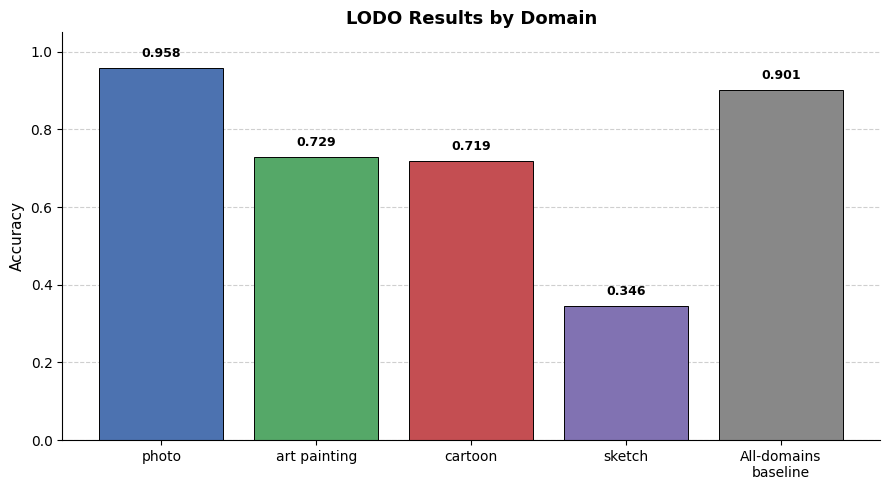

In [6]:
import matplotlib.pyplot as plt

# Data
results = {
    "photo": 0.9581,
    "art_painting": 0.7293,
    "cartoon": 0.7186,
    "sketch": 0.3461,
    "All-domains baseline": 0.9010
}

# Prepare labels & values; wrap long label onto two lines for neatness
labels = []
values = []
for k, v in results.items():
    if "All-domains" in k:
        labels.append("All-domains\nbaseline")   # wrap long label
    else:
        labels.append(k.replace("_", " "))       # nicer display for underscores
    values.append(v)

# Plot
fig, ax = plt.subplots(figsize=(9, 5))
x = range(len(labels))

# Draw bars; make baseline visually distinct
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#888888"]
bars = ax.bar(x, values, color=colors, edgecolor="black", linewidth=0.7)

# Axis and ticks
ax.set_ylim(0, 1.05)
ax.set_ylabel("Accuracy", fontsize=11)
ax.set_title("LODO Results by Domain", fontsize=13, weight="bold")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=10, rotation=0, ha="center")

# Add horizontal grid lines for readability (below bars)
ax.yaxis.grid(True, linestyle="--", alpha=0.6)
ax.set_axisbelow(True)

# Annotate values above bars with consistent alignment
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,
        f"{val:.3f}",
        ha="center",
        va="bottom",
        fontsize=9,
        fontweight="semibold"
    )

# Tidy up spines
for spine in ("top", "right"):
    ax.spines[spine].set_visible(False)

plt.tight_layout()
# Save optionally:
# fig.savefig("lodo_results_bar.png", dpi=300)
plt.show()
